Section A: Load & Explore (10 marks)
Q1. Dataset Exploration

In [ ]:
import re, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:

df = pd.read_csv('/tweets.csv')

In [ ]:
label_counts = df['target'].value_counts()
print(label_counts)

target
0    9256
1    2114
Name: count, dtype: int64


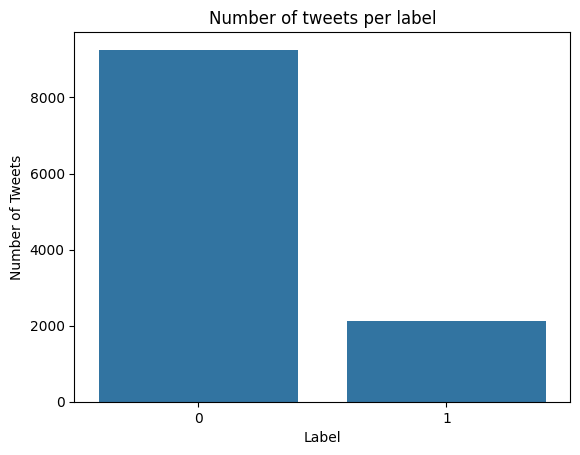

In [ ]:
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Label')
plt.ylabel('Number of Tweets')
plt.title('Number of tweets per label')
plt.show()

In [ ]:
for label in [0, 1]:
    print(f"\nLabel {label}:")
    print(df[df['target'] == label][['text']].sample(5))


Label 0:
                                                   text
876   Why are we not hiring every large water carryi...
1083   Like , I'm really talking about blending genera…
1576  NATO...Bombed...Libya...Statehood...Russia...F...
9405  The new baby arrives in a snowstorm. Weighing ...
2085  Energetic and Comedic Redhead Teen, just seen ...

Label 1:
                                                   text
4324  SIGN: Justice for Dog Tied to Rock and Dumped ...
9719  75 buses and 20 ambulances of refugees, mostly...
9793  14/1/1942 This day 1942 British tug Mercia min...
3746  Hi Lisa, I'm very sorry about this, a freight ...
9896  Locals residing at the foot of Taal Volcano we...


Section B: Text Preprocessing Pipeline
Q2. Text Cleaning Pipeline

In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

stop_words = set(stopwords.words('english')) # Moved this line here

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
stop_words = set(stopwords.words('english'))
punct_tbl = str.maketrans('', '', string.punctuation)

url_pat = re.compile(r'https?://\S+|www\.\S+')
mention_pat = re.compile(r'@\w+')
hashtag_pat = re.compile(r'#\w+')

def clean_text(s: str) -> str:
    s = url_pat.sub(' ', s)
    s = mention_pat.sub(' ', s)
    s = hashtag_pat.sub(' ', s)
    s = s.lower()
    s = s.translate(punct_tbl)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def tokenize_remove_stopwords(s: str):
    tokens = word_tokenize(s)
    tokens = [t for t in tokens if t not in stop_words and t.isalpha()]
    return tokens

# Store intermediate steps for later comparisons
df['clean_text'] = df['text'].astype(str).apply(clean_text)
df['tokens'] = df['clean_text'].apply(tokenize_remove_stopwords)



Q3. Stemming vs Lemmatization



In [ ]:
ps = PorterStemmer()
wnl = WordNetLemmatizer()

def stem_tokens(tokens):
    return [ps.stem(t) for t in tokens]

def lemma_tokens(tokens):
    return [wnl.lemmatize(t) for t in tokens]

sample_for_compare = df.sample(5, random_state=123)[['text','tokens']].copy()
sample_for_compare['stemmed'] = sample_for_compare['tokens'].apply(stem_tokens)
sample_for_compare['lemmatized'] = sample_for_compare['tokens'].apply(lemma_tokens)

# Display side-by-side table
compare_df = sample_for_compare[['text','tokens','stemmed','lemmatized']].reset_index(drop=True)
print("\nStemming vs Lemmatization (5 samples):")
display(compare_df)


Stemming vs Lemmatization (5 samples):


,text,tokens,stemmed,lemmatized
0,They'd get annihilated by '01 Miami https://t....,"[theyd, get, annihilated, miami]","[theyd, get, annihil, miami]","[theyd, get, annihilated, miami]"
1,"So far: Iran lost her top-terrorist, inflicted...","[far, iran, lost, topterrorist, inflicted, zer...","[far, iran, lost, topterrorist, inflict, zero,...","[far, iran, lost, topterrorist, inflicted, zer..."
2,Stretcher 😂,[stretcher],[stretcher],[stretcher]
3,Rest and be thankful before the festive mayhem...,"[rest, thankful, festive, mayhem]","[rest, thank, festiv, mayhem]","[rest, thankful, festive, mayhem]"
4,The sirens are blaring☢☣☢☣ https://t.co/iUArQN...,[sirens],[siren],[siren]


Section C: Analysis & Summary
Q4. Frequent Words Analysis

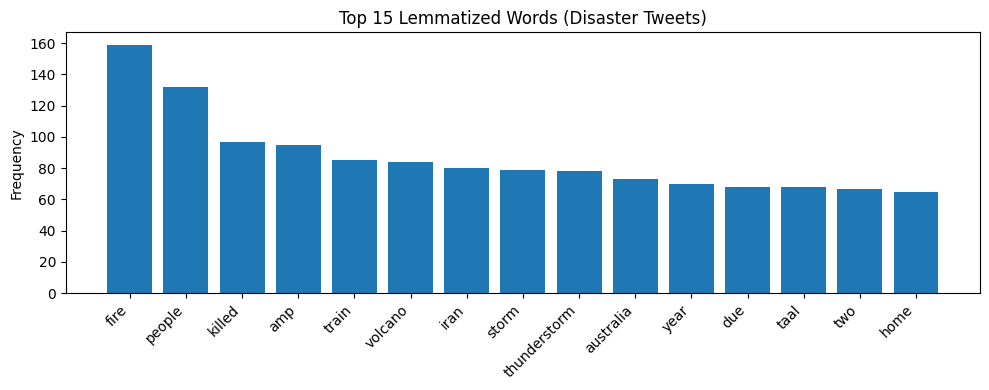

In [ ]:
df_disaster = df[df['target']==1].copy() # Changed 'label' to 'target'
df_disaster['lemmas'] = df_disaster['tokens'].apply(lemma_tokens)

from collections import Counter
all_lemmas_disaster = [w for toks in df_disaster['lemmas'] for w in toks]
freq = Counter(all_lemmas_disaster).most_common(15)

words, counts = zip(*freq) if freq else ([], [])
plt.figure(figsize=(10,4))
plt.bar(words, counts)
plt.title('Top 15 Lemmatized Words (Disaster Tweets)')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Tweet Length Analysis

In [ ]:
df['len_raw_tokens'] = df['text'].astype(str).apply(lambda s: len(word_tokenize(s)))
df['len_clean_tokens'] = df['tokens'].apply(len)

avg_before = df['len_raw_tokens'].mean()
avg_after  = df['len_clean_tokens'].mean()
print(f"Average tweet length BEFORE preprocessing: {avg_before:.2f} tokens")
print(f"Average tweet length AFTER preprocessing:  {avg_after:.2f} tokens")
print("Preprocessing typically reduces noise by removing URLs, mentions, punctuation, and stopwords.")


Average tweet length BEFORE preprocessing: 20.78 tokens
Average tweet length AFTER preprocessing:  8.81 tokens
Preprocessing typically reduces noise by removing URLs, mentions, punctuation, and stopwords.


Section D: Machine Learning Model

Q6. TF-IDF Representation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer # Import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
X = tfidf.fit_transform(df['clean_text'])
y = df['target'].values # Changed 'label' to 'target'

Q7. Model Training

In [ ]:
from sklearn.model_selection import train_test_split # Import train_test_split
from sklearn.linear_model import LogisticRegression # Import LogisticRegression
from sklearn.metrics import classification_report # Import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

clf = LogisticRegression(max_iter=200, n_jobs=None)  # n_jobs not needed for LBFGS
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("\nPerformance (Accuracy, Precision, Recall, F1):")
print(classification_report(y_test, y_pred, digits=3))


Performance (Accuracy, Precision, Recall, F1):
              precision    recall  f1-score   support

           0      0.875     0.988     0.928      1851
           1      0.880     0.383     0.534       423

    accuracy                          0.876      2274
   macro avg      0.878     0.686     0.731      2274
weighted avg      0.876     0.876     0.855      2274



Q8. Results & Interpretation

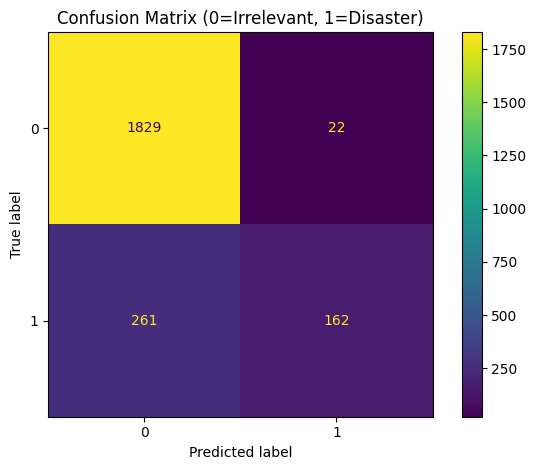

False Positives (0→1): 22  |  False Negatives (1→0): 261


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Import confusion_matrix and ConfusionMatrixDisplay
import sklearn.metrics as metrics # Import metrics

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1]) # Use ConfusionMatrixDisplay directly
disp.plot(values_format='d')
plt.title('Confusion Matrix (0=Irrelevant, 1=Disaster)')
plt.tight_layout()
plt.show()

# Quick notes you can expand in the report:
fp = cm[0,1]
fn = cm[1,0]
print(f"False Positives (0→1): {fp}  |  False Negatives (1→0): {fn}")